# **Data Science Intern Python Assignment - Phivian Phun**
This python notebook builds a predictive model on Titanic Data. \
Public Git Repository: https://github.com/hypephib/Cadent-Interview-Problem \
Run this on Colab with Python 3 and GPU as an acelerator. 

## Downloading Dataset from Kaggle
I downloaded data from Kaggle commands using my tokens. \
You can find more information about the data here: https://www.kaggle.com/c/titanic/data

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
import json
token = {"username":"phivianphun","key":"6288f9cfc09c8e64e63005ff90707f59"}
with open('kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!ls

kaggle.json  sample_data


In [0]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 51.3MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 24.3MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.27MB/s]


## Install Dependencies

In [7]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)


## Preprocessing: Feature Extraction

Implementing feature extraction with a little bit of a twist. Used basic extractions from this tutorial: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/


In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import collections 

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualization

Text(0.5, 1.0, 'Male')

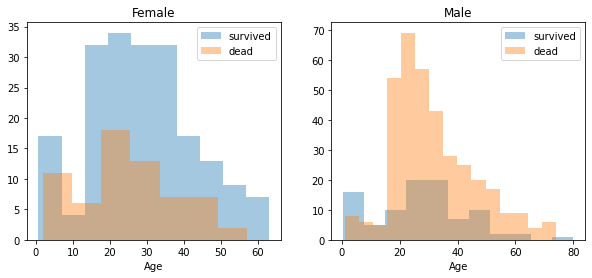

In [9]:
fig, axes = plt.subplots(1, 2,figsize=(10, 4))
female = train[train['Sex']=='female']
male = train[train['Sex']=='male']

ax = sns.distplot(female[female['Survived']==1].Age.dropna(), bins="auto", label = "survived", ax = axes[0], kde =False)
ax = sns.distplot(female[female['Survived']==0].Age.dropna(), bins="auto", label = "dead", ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(male[male['Survived']==1].Age.dropna(), bins="auto", label = "survived", ax = axes[1], kde = False)
ax = sns.distplot(male[male['Survived']==0].Age.dropna(), bins="auto", label = "dead", ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

Based on this visualization, females are more likely to survive than males, especially young adults. 

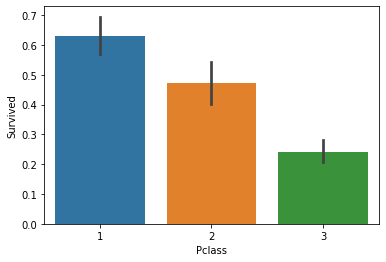

In [10]:
sns.barplot(x='Pclass', y='Survived', data=train)

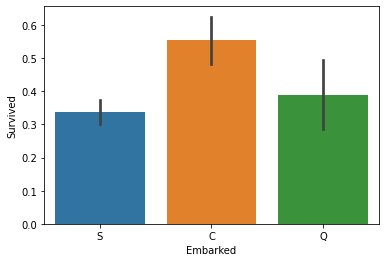

In [11]:
sns.barplot(x='Embarked', y='Survived', data=train)

There more survivors from the 1st class and embarked from Cherbourg. 

### Whole Dataset: Feature Extraction


In [12]:
# Expand "Name" column into readable data 
# Format: Last Name, Title First Name Middle Name
# If female, Format: Husband's Last Name Mrs. Husband's First Name Husbands Last Name (Maiden Full Name)

titles = train["Name"].str.split(", ", n = 1, expand = True)[1]
titles = titles.str.split(".", n = 1, expand = True)[0]
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [13]:
# List of features with missing values
train.columns[train.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [0]:
 def feature_extraction(df):
  # Extract Basic Titles: Mr, Master, Mrs, Miss
  # ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
      #  'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
      #  'Jonkheer']
  mrs = ["the Countess", "Lady", "Dr", "Mme", "Dona"]
  miss = ["Mlle", "Ms"]
  mr = ["Major", "Rev", "Col", "Capt","Don","Jonkheer", "Dr", "Sir"]

  titles = df["Name"].str.split(", ", n = 1, expand = True)[1]
  titles = titles.str.split(".", n = 1, expand = True)[0]
  df["Title"] = titles

  df.loc[(df.Title.isin(mrs)) & (df.Sex == "female"), "Title"] = "Mrs" 
  df.loc[df.Title.isin(miss), "Title"] = "Miss"
  df.loc[df.Title.isin(mr), "Title"] = "Mr"  

  # Extract Cabin 
  df["Deck"] = df["Cabin"].str[0]

  # Extract Family Size 
  df["Family_Size"] = df["SibSp"] + df["Parch"]

  # Extract Age*Class
  df['Age*Class']=df['Age']*df['Pclass']

  # Extract Fare Per Person 
  df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
  
  # Missing Categories 
  df["Deck"].fillna("Unknown", inplace=True)
  df["Embarked"].fillna("Unknown", inplace=True)
  return df

def drop_columns(df):
  return df.drop(columns=["Name", "Ticket", "Cabin", "PassengerId"])


In [15]:
clean_train = feature_extraction(train)
clean_train = drop_columns(clean_train)
clean_train = pd.get_dummies(clean_train)


clean_test = feature_extraction(test)
clean_test = drop_columns(clean_test)
clean_test = pd.get_dummies(clean_test)

columns = list(clean_train.columns)
columns.remove("Survived")

for x in columns:
  if x not in clean_test.columns:
    clean_test[x] = 0

difference = set(columns) - set(clean_test.columns)
if len(difference) > 0:
  print("Training and Test set DO NOT MATCH!")
  print(difference)

print(clean_train.shape)
print(clean_train.columns)
print(clean_test.shape)
print(clean_test.columns)

(891, 28)
Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size',
       'Age*Class', 'Fare_Per_Person', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_Unknown', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtype='object')
(418, 27)
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Age*Class',
       'Fare_Per_Person', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_Unknown', 'Embarked_Unknown', 'Deck_T'],
      dtype='object')


## Pipeline: Preprocessing, Hyperparameter Tuning, Model Evaluation
Let's compare some existing models and algorithms from Scikit Learn.

* Logistic Regression
* KNN
* Decision Trees
* Random Forest 
* SVM



In [0]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

#Split dataset to target and features
y = clean_train["Survived"]
X = clean_train.drop(columns=["Survived"])

#Since we only have ground truth from training, 
#Let's split the training data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Median Imputation is needed for Age missing data 

Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(SimpleImputer(strategy='median'),
                          StandardScaler(),
                          LogisticRegression())
scores = cross_val_score(pipe, X, y, cv=10)
np.mean(scores)

0.8316853932584269

KNN Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
pipe = make_pipeline(SimpleImputer(strategy='median'),
                          StandardScaler(),
                          KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 10)}
grid = GridSearchCV(pipe, param_grid, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

{'kneighborsclassifier__n_neighbors': 9}

In [19]:
grid.score(X_test, y_test)

0.8026905829596412

Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
pipe = make_pipeline(SimpleImputer(strategy='median'),
                          DecisionTreeClassifier())
scores = cross_val_score(pipe, X, y, cv=10)
np.mean(scores)

0.7991635455680399

With Cost Complexity Pruning

In [21]:
pipe = make_pipeline(SimpleImputer(strategy='median'),
                          DecisionTreeClassifier())
param_grid = {'decisiontreeclassifier__ccp_alpha': np.linspace(0., 0.03, 20)}
grid = GridSearchCV(pipe,
                    param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

{'decisiontreeclassifier__ccp_alpha': 0.01894736842105263}

In [32]:
grid.score(X_test, y_test)

0.8071748878923767

Random Forests 

In [23]:
from sklearn.ensemble import RandomForestClassifier 

pipe = make_pipeline(SimpleImputer(strategy='median'),
                          RandomForestClassifier(warm_start=True))
param_grid = {'randomforestclassifier__n_estimators': range(1, 100, 5)}
grid = GridSearchCV(pipe,
                    param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

{'randomforestclassifier__n_estimators': 16}

In [24]:
grid.score(X_test, y_test)

0.8161434977578476

Support Vector Machine

In [25]:
from sklearn.svm import SVC
pipe = make_pipeline(SimpleImputer(strategy='median'),
                      StandardScaler(),
                      SVC())
param_grid = {'svc__C': np.logspace(-3, 2, 6),
              'svc__gamma': np.logspace(-3, 2, 6) / X_train.shape[0]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.0014970059880239522}

In [26]:
grid.score(X_test, y_test)

0.8071748878923767

All models seem to perform pretty well around 80% on average cross validation score. But Random Forests performed the best with 84% on a good day. It is inconsistent with its results so let's analyze both Logistic Regression and Random Forests.  

## Prediction with Logistic Regression



In [27]:
log_pipe = make_pipeline(SimpleImputer(strategy='median'),
                          StandardScaler(),
                          LogisticRegression())
log_pipe.fit(X,y)
predictions = log_pipe.predict(clean_test)
log_submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
log_submission[log_submission['Survived'] == 1].shape[0]

170

## Prediction with Random Forest

In [28]:
randforest_pipe = make_pipeline(SimpleImputer(strategy='median'),
                          RandomForestClassifier(warm_start=True))
param_grid = {'randomforestclassifier__n_estimators': range(1, 100, 5)}
randforest_grid = GridSearchCV(randforest_pipe,
                    param_grid=param_grid, cv=10)
randforest_grid.fit(X_train, y_train)
predictions = randforest_grid.predict(clean_test)

randforest_submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
randforest_submission[randforest_submission['Survived'] == 1].shape[0]

317

In [29]:
log_passengers_survived = log_submission[log_submission['Survived'] == 1 ]['PassengerId']
randforest_passengers_survived = randforest_submission[randforest_submission['Survived'] == 1]['PassengerId']

list(log_passengers_survived) == list(randforest_passengers_survived)

False

## Evaluation 

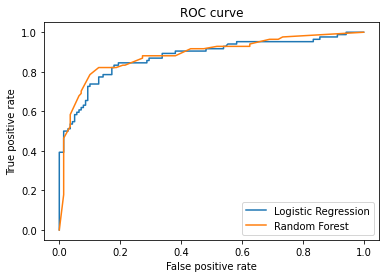

In [30]:
from sklearn.metrics import roc_curve
log_pipe = make_pipeline(SimpleImputer(strategy='median'),
                          StandardScaler(),
                          LogisticRegression())
log_pipe.fit(X_train,y_train)
y_pred_rt = log_pipe.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

y_pred_rf = randforest_grid.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)


plt.plot(fpr_rt_lm, tpr_rt_lm, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
randforest_submission.to_csv("submission.csv")